In [172]:
import math
import mmgdynamics as mmg
import mmgdynamics.calibrated_vessels as cvs
import matplotlib.pyplot as plt # Just for demostration

from collections import namedtuple
import numpy as np
import scipy

In [173]:
class DIRCOL:
    def __init__(self, N, nx, nu, dt, tolerance, initial_state, final_state, Q, R, Qf):
        # Initialization Variables
        self.vessel = mmg.Vessel(**cvs.kvlcc2_l64)

        self.N = N # Number of collocation points
        self.nx = nx # Number of state variables
        self.nu = nu # Number of control variables
        self.dt = dt # Time step (seconds)
        self.tolerance = tolerance

        self.initial_state = initial_state
        self.final_state = final_state

        self.min_psi = 0.
        self.max_psi = np.pi * 2

        self.min_vel = 1.
        self.max_vel = 20.

        self.min_controls = [0., -np.pi]
        self.max_controls = [5., np.pi]
        
        self.Q = Q
        self.R = R
        self.Qf = Qf

    def state2comp(self, s: np.ndarray):
        pos = s[:2]
        psi = s[2]
        uvr = s[3:]
        return pos, psi, uvr

    def control2comp(self, u: np.ndarray):
        nps = u[0]
        delta = u[1]
        return nps, delta

    def dynamics(self, s, u):
        pos, psi, uvr = self.state2comp(s)
        nps, delta = self.control2comp(u)

        uvr_new, eta = mmg.pstep(
            X           = uvr,
            pos         = pos,
            vessel      = self.vessel,
            dT          = self.dt,       # in seconds
            nps         = nps,      # propeller (nps) revs per second
            delta       = delta,    # rudder (delta) angle in radians
            psi         = psi,      # vessel (psi) heading in radians
            water_depth = None,     # No water depth
            fl_psi      = None,     # No current angle
            fl_vel      = None,     # No current velocity
            w_vel       = None,     # No wind velocity
            beta_w      = None      # No wind angle
        )

        duvr = mmg.step(
            X           = uvr,
            vessel      = self.vessel,
            dT          = self.dt,       # in seconds
            nps         = nps,      # propeller (nps) revs per second
            delta       = delta,    # rudder (delta) angle in radians
            psi         = psi,      # vessel (psi) heading in radians
            water_depth = None,     # No water depth
            fl_psi      = None,     # No current angle
            fl_vel      = None,     # No current velocity
            w_vel       = None,     # No wind velocity
            beta_w      = None      # No wind angle
        )

        sp1 = np.concatenate((eta, uvr_new))
        Δs = np.concatenate((uvr, duvr))
        return sp1, Δs

    def verify_dynamics(self):
        ### Testing dynamics function
        state = [0., 0., np.pi/4., 2., 0., 0.]
        control = np.array([1, 0])

        states = [state]
        for i in range(self.N):
            sp1, Δs = self.dynamics(states[i], control) 
            states.append(sp1)

        self.display_path(states)
        return states

    def display_path(self, states):
        ps = list(zip(*states))
        plt.scatter(ps[0], ps[1])
        plt.show()

        print(f"min psi: {min(ps[2])}\t max psi: {max(ps[2])}")

    def make_guess(self, states_sim):
        state_guess = states_sim.flatten()
        #state_guess = np.linspace(self.initial_state, self.final_state, self.N).flatten()
        #state_guess = np.zeros(self.N * self.nx)
        #control_guess = np.zeros(self.N * self.nu)
        control_guess = np.tile(np.array([1.0, 0.0]), self.N)
        initial_Z = np.concatenate((state_guess, control_guess))
        self.initial_Z = initial_Z
        return initial_Z

    def variables_to_components(self, variables):
        states_flat = variables[:self.N*self.nx]
        controls_flat = variables[self.N*self.nx:]

        states = []
        for i in range(self.N):
            state = states_flat[i*self.nx:(i+1)*self.nx]
            states.append(state)

        controls = []
        for i in range(self.N):
            control = controls_flat[i*self.nu:(i+1)*self.nu]
            controls.append(control)

        return np.array(states), np.array(controls)
    
    def cost(self, variables):
        states, controls = self.variables_to_components(variables)
        cost = 0
        
        for i in range(self.N-1):
            state = states[i]
            control = controls[i]
            # LQR Cost
            cost += 0.5 * (state-self.final_state) @ self.Q @ (state-self.final_state)
            cost += 0.5 * control @ self.R @ control
        
        cost += (states[-1]-self.final_state) @ self.Qf @ (states[-1]-self.final_state) # LQR terminal cost
        
        return cost
    
    def hermite_simpson(self, s1, s2, u1):
        s1p1, ds1 = self.dynamics(s1, u1)
        s2p1, ds2 = self.dynamics(s2, u1)

        midpoint = 0.5 * (s1 + s2) + self.dt/8.0 * (ds1 - ds2)
        midp1, dmid = self.dynamics(midpoint, u1)

        f = s1 + self.dt/6.0 * (ds1 + 4.0 * dmid + ds2) - s2
        return f
    
    def forward_euler(self, s1, s2, u1):
        sp1, ds1 = self.dynamics(s1, u1)
        f = s1 + self.dt * ds1 - s2
        #f = sp1 - s2
        return f
    
    def eq_constraints(self, variables):
        states, controls = self.variables_to_components(variables)
        constraints = []

        initial_constraint = states[0] - self.initial_state
        final_constraint = states[-1] - self.final_state

        constraints.extend(list(initial_constraint))
        constraints.extend(list(final_constraint))

        for i in range(self.N-1):
            s1 = states[i]
            s2 = states[i+1]
            u1 = controls[i]
            f = self.forward_euler(s1, s2, u1)
            constraints.extend(f)

        assert np.all(np.isfinite(constraints)), "NaN or Inf in constraints"
        return np.array(constraints)
    
    def ineq_constraints(self, variables):
        states, controls = self.variables_to_components(variables)
        constraints = []

        for i in range(self.N-1):
            state = states[i]
            control = controls[i]
            #constraints.append(state[2] - self.min_psi)
            #constraints.append(self.max_psi - state[2])
            #constraints.extend(state[3:] - self.min_vel)
            #constraints.extend(-state[3:] + self.max_vel)
            constraints.extend(control - self.min_controls)
            constraints.extend(-control + self.max_controls)

        assert np.all(np.isfinite(constraints)), "NaN or Inf in constraints"
        return constraints
    
    def do_dircol(self):
        constraints = [
            {"type": "eq", "fun": self.eq_constraints},
            {"type": "ineq", "fun": self.ineq_constraints}
        ]

        self.sol = scipy.optimize.minimize(
            fun=self.cost,
            x0=self.initial_Z,
            method="SLSQP",
            constraints=constraints,
            jac='2-point',             # force numerical gradient
            options={
                "disp": True,
                "maxiter": 1000,
                "ftol": 1e-6
            }
        )

        print(self.sol)

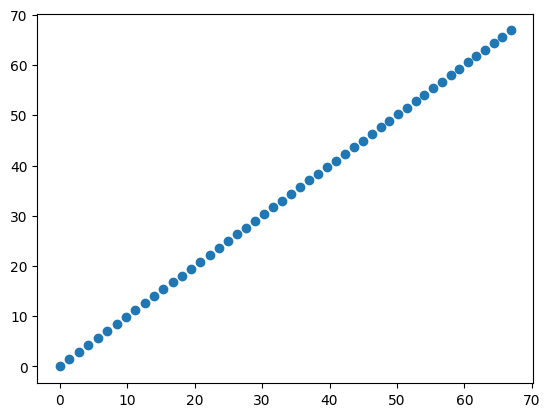

min psi: 0.7853981633974483	 max psi: 0.7853981633974483


KeyboardInterrupt: 

In [174]:
helper = DIRCOL(
    N=50, 
    nx=6, 
    nu=2, 
    dt=1, 
    tolerance=1e-6, 
    initial_state=[0., 0., np.pi/4., 2., 0., 0.], 
    final_state=[70., 70., 0., 2., 0., 0.],
    Q=np.eye(6),
    R=np.eye(2),
    Qf=np.eye(6)
    )
states_sim = helper.verify_dynamics()
helper.make_guess(np.array(states_sim))
helper.do_dircol()

states, controls = helper.variables_to_components(helper.sol.x)
helper.display_path(states)